In [34]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset

import sys

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import sympy as sp

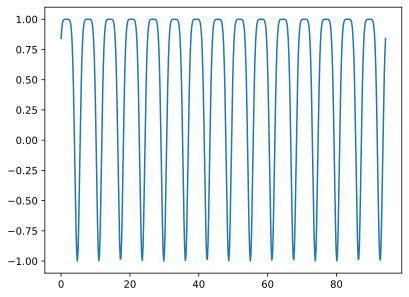

In [104]:
N = 500
seq = torch.zeros(N)
t = torch.linspace(0, 30*torch.pi, N)
seq = torch.sin(t + torch.cos(t))
plt.plot(t, seq)
plt.axis('tight')
plt.show()

In [84]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self, x):
    
    # run through the RNN layer
    y,hidden = self.rnn(x) # no explicit hidden state initialization
    
    # and the output (linear) layer
    y = self.out(y)
    
    return y,hidden

In [85]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  5 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  =  35 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

# create an instance of the model and inspect
net = rnnnet(input_size,num_hidden,num_layers)

X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X)
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([35, 1, 1])
torch.Size([35, 1, 1])
torch.Size([1, 1, 5])


In [86]:
seq[:seqlength]

tensor([ 0.8415,  0.9212,  0.9655,  0.9872,  0.9962,  0.9992,  0.9999,  1.0000,
         1.0000,  1.0000,  1.0000,  0.9998,  0.9985,  0.9939,  0.9811,  0.9525,
         0.8968,  0.8006,  0.6509,  0.4392,  0.1679, -0.1455, -0.4661, -0.7463,
        -0.9366, -0.9998, -0.9229, -0.7215, -0.4350, -0.1131,  0.1973,  0.4632,
         0.6686,  0.8125,  0.9040])

In [87]:
# test the model with some data
somedata = seq[:seqlength].view(seqlength,1,1)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue,seq[seqlength].view(1,1))

tensor(1.0870, grad_fn=<MseLossBackward0>)

In [105]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet(input_size,num_hidden,num_layers)
optimizer = torch.optim.SGD(net.parameters(),lr=.001)



# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc    = []
  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = seq[timei:timei+seqlength].view(seqlength,1,1)
    y = seq[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hidden_state = net(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())

    # also get pred SIGN accuracy
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    accuracy = 100*(truesign==predsign)
    segacc.append(accuracy)
  
  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  signaccuracy[epochi] = np.mean(segacc)
  
  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

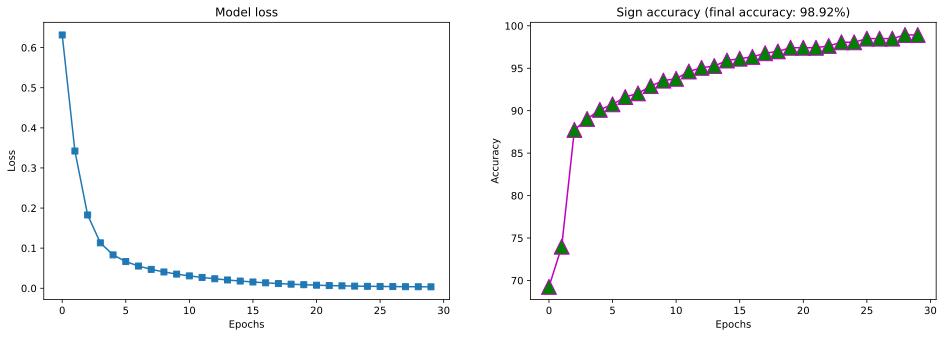

In [106]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

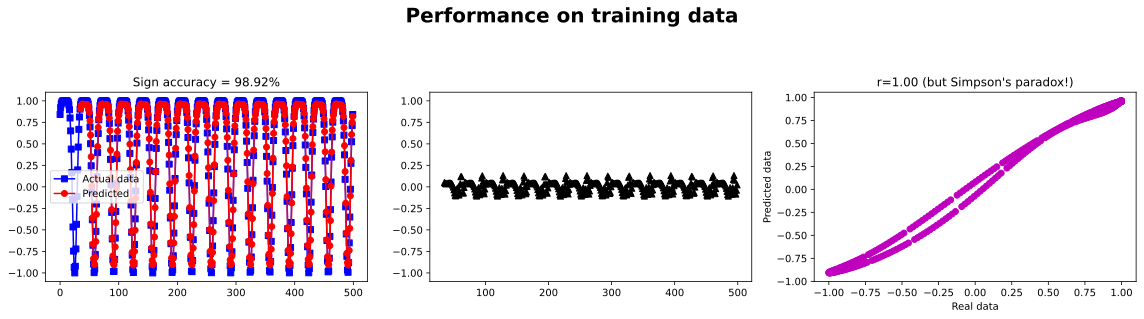

In [107]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = seq[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


# compute sign-accuracy
truesign = np.sign(seq.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(seq,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(seq-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(seq[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(seq[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

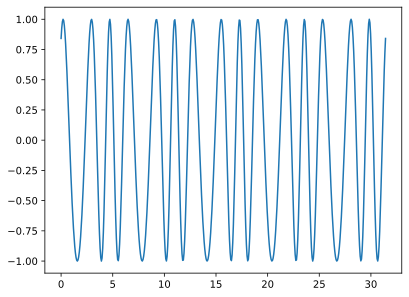

In [100]:
seq2 = torch.zeros(N)
t2 = torch.linspace(0, 10*torch.pi, N)
seq2 = torch.sin(t + torch.cos(t2))
plt.plot(t2, seq2)
plt.axis('tight')
plt.show()

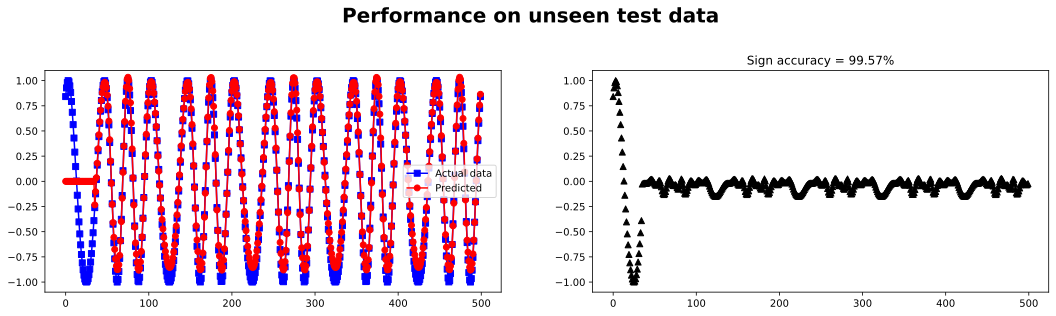

In [103]:
## now test the network!
# note: no learning here!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
for timei in range(N-seqlength):

  # grab a snippet of data
  X = seq2[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


# compute sign-accuracy
truesign = np.sign(seq2.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(seq2,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(seq2-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

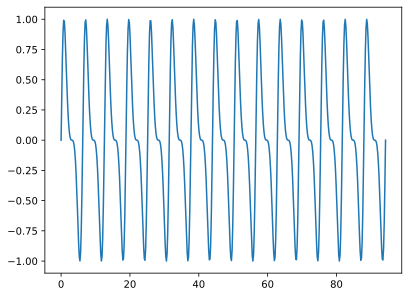

In [99]:
seq3 = torch.zeros(N)
t3 = torch.linspace(0, 30*torch.pi, N)
seq3 = torch.sin(t + torch.sin(t3))
plt.plot(t3, seq3)
plt.axis('tight')
plt.show()

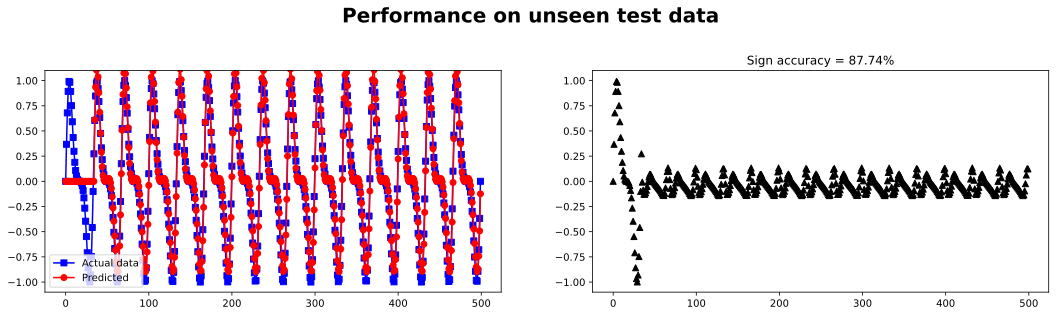

In [102]:
## now test the network!
# note: no learning here!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
for timei in range(N-seqlength):

  # grab a snippet of data
  X = seq3[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


# compute sign-accuracy
truesign = np.sign(seq3.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(seq3,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(seq3-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

In [149]:
seq4 = seq[:seqlength]
seq4

tensor([ 0.8415,  0.9212,  0.9655,  0.9872,  0.9962,  0.9992,  0.9999,  1.0000,
         1.0000,  1.0000,  1.0000,  0.9998,  0.9985,  0.9939,  0.9811,  0.9525,
         0.8968,  0.8006,  0.6509,  0.4392,  0.1679, -0.1455, -0.4661, -0.7463,
        -0.9366, -0.9998, -0.9229, -0.7215, -0.4350, -0.1131,  0.1973,  0.4632,
         0.6686,  0.8125,  0.9040])

In [133]:
seq4.shape


torch.Size([501])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

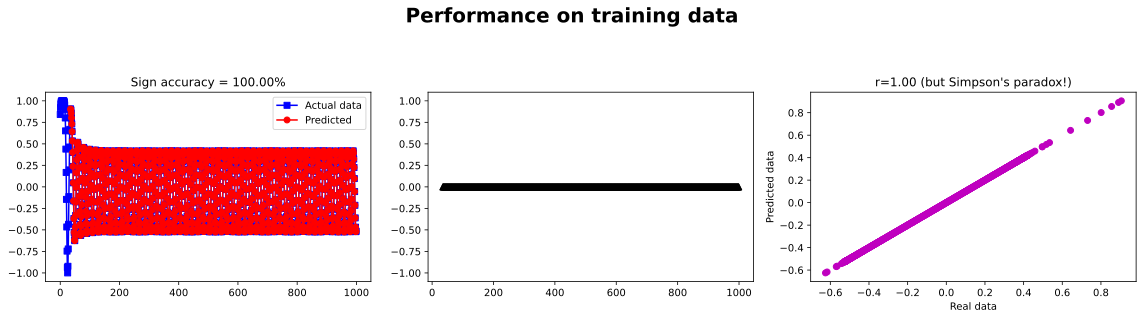

In [150]:
# initialize hidden state
h = np.zeros((2*N,num_hidden))

# initialize predicted values
yHat = np.zeros(2*N)
yHat[:] = np.nan


# loop over time segments
for timei in range(2*N-seqlength):
  print(timei)
  # grab a snippet of data
  X = seq4[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  # print(yy[-1][0])
  seq4 = torch.cat((seq4, yy.detach()[-1][0]))
  h[timei+seqlength,:] = hh.detach()


# compute sign-accuracy
truesign = np.sign(seq4.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(seq,'bs-',label='Actual data')
ax[0].plot(seq4,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(seq4-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(seq4[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(seq4[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

In [136]:
seq4

tensor([ 0.8415,  0.9212,  0.9655,  0.9872,  0.9962,  0.9992,  0.9999,  1.0000,
         1.0000,  1.0000,  1.0000,  0.9998,  0.9985,  0.9939,  0.9811,  0.9525,
         0.8968,  0.8006,  0.6509,  0.4392,  0.1679, -0.1455, -0.4661, -0.7463,
        -0.9366, -0.9998, -0.9229, -0.7215, -0.4350, -0.1131,  0.1973,  0.4632,
         0.6686,  0.8125,  0.9040,  0.9564,  0.9830,  0.9946,  0.9987,  0.9998,
         1.0000,  1.0000,  1.0000,  1.0000,  0.9999,  0.9990,  0.9956,  0.9857,
         0.9623,  0.9150,  0.8310,  0.6967,  0.5018,  0.2454, -0.0595, -0.3824,
        -0.6784, -0.8971, -0.9967, -0.9567, -0.7855, -0.5169, -0.1996,  0.1178,
         0.3979,  0.6200,  0.7797,  0.8840,  0.9454,  0.9777,  0.9925,  0.9981,
         0.9997,  1.0000,  1.0000,  1.0000,  1.0000,  0.9999,  0.9994,  0.9970,
         0.9893,  0.9703,  0.9306,  0.8578,  0.7381,  0.5600,  0.3194,  0.0251,
        -0.2969, -0.6050, -0.8490, -0.9834, -0.9810, -0.8424, -0.5955, -0.2861,
         0.0356,  0.3283,  0.5669,  0.74

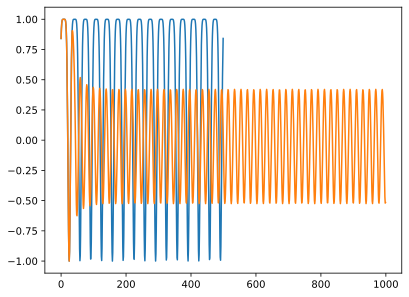

In [158]:
plt.plot(seq, label='Actual data')
plt.plot(seq4,label='Predicted')
plt.axis('tight')
plt.show()